In [1]:
import os, sys, random, pandas as pd, numpy as np
from tqdm import tqdm
import torch


# set random seed
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
SEED = 10
random.seed(SEED)
np.random.seed(SEED)
torch.random.manual_seed(SEED)
sys.path.append('../')


# load package requirments
from VGFM.utils import  generate_steps, parser, _valid_criterions
from VGFM.plots import plot_comparision
from VGFM.train import pretrain, train
from VGFM.models import  FNet, ODEFunc2
from VGFM.constants import DATA_DIR
from VGFM.exp import setup_exp
from VGFM.eval import generate_plot_data
from torchdiffeq import odeint_adjoint as odeint

### Defining parameters and loading dataset

In [ ]:
import torch.optim as optim

dim=50
f_net = FNet(in_out_dim=dim, hidden_dim=256, n_hiddens=5, activation='leakyrelu')

import sys

# Simulate the command-line arguments
sys.argv = [
    'VGFM Training',
    '-d', 'file',
    '-c', 'ot1',
    '-n', 'cite50_ho2',# experiment name
    '--hold-one-out',
    '-ho', '2',
    '-e1', '5000',
    '-e2', '30',
    '-bs', '256',
    '-r', '0.01',
    '-rm', '5',
    '--norm_cost'
]

args = parser.parse_args()
opts = vars(args)

# Display the parsed arguments
print(opts)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


{'dataset': 'file', 'time_col': None, 'name': 'cite50_ho2', 'output_dir': 'd:\\NeurIPS_2025_VGFM\\VGFM\\results', 'criterion': 'ot1', 'sample_with_replacement': False, 'hold_one_out': True, 'hold_out': 2, 'apply_losses_in_time': True, 'learning_rate1': 0.001, 'epochs1': 5000, 'norm_cost': True, 'reg': 0.01, 'reg_m': 5.0, 'n_big_batches': 1, 'n_batch': 256, 'learning_rate2': 0.0001, 'epochs2': 30}


device(type='cpu')

In [3]:
df = pd.read_csv(DATA_DIR + '/cite_pca50.csv')
df=df.iloc[:,:dim+1]
 # make output dir
if not os.path.isdir(opts['output_dir']):
    os.makedirs(opts['output_dir'])
exp_dir, logger = setup_exp(opts['output_dir'], opts, opts['name'])
  # load dataset
logger.info(f'Loading dataset: '+opts['name'])


from sklearn.preprocessing import StandardScaler
import pandas as pd

# cols_to_scale = [c for c in df.columns if c != "samples"]

# scaler = StandardScaler()
# df_scaled = df.copy()
# df_scaled[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
# df = df_scaled


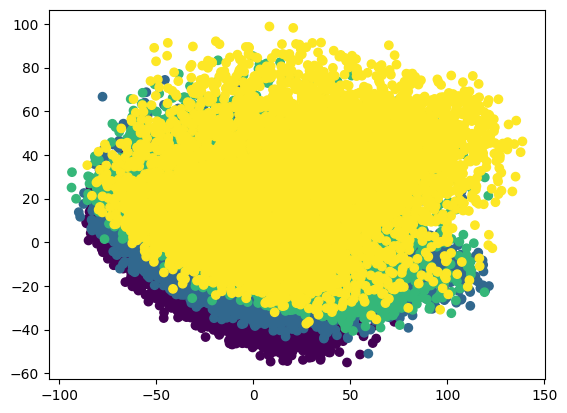

In [4]:
import matplotlib.pyplot as plt
plt.scatter(df.iloc[:,1],df.iloc[:,2],c=df.iloc[:,0])

In [5]:
args.hold_out

2

In [6]:
groups = sorted([g for g in df.samples.unique() if g != args.hold_out])
steps = generate_steps(groups)
optimizer = torch.optim.Adam(f_net.parameters())
opts['criterion']='ot1'
criterion =  _valid_criterions[opts['criterion']]()

# # logger.info(f'Extracting parameters')
use_cuda = torch.cuda.is_available()
# sample_with_replacement = opts['sample_with_replacement' ]
# apply_losses_in_time = opts['apply_losses_in_time']

    
local_losses = {f'{t0}:{t1}':[] for (t0, t1) in steps}
batch_losses = []
globe_losses = []

In [7]:
f_net=f_net.to(device)

In [8]:
initial_size=df[df['samples']==0].x1.shape[0]
initial_size

7476

In [9]:
sample_sizes = df.groupby('samples').size()
ref0 = sample_sizes / sample_sizes.iloc[0]  
relative_mass = torch.tensor(ref0.values) 
relative_mass

tensor([1.0000, 0.9362, 1.2722, 0.9703], dtype=torch.float64)

In [10]:
sample_size = (df[df['samples']==0.0].values.shape[0],)

### Training with $\mathcal{L}_{\rm VGFM}$

In [11]:
f_net, v_losses, g_losses, losses = pretrain(
    f_net,
    df,
    optimizer,
    n_epoch=args.epochs1,
    hold_out=args.hold_out,
    logger=logger,
    relative_mass=relative_mass,
    reg=args.reg,
    reg_m=[args.reg_m, np.inf],
    norm_cost=args.norm_cost,
    batch_size=args.n_batch
)


relative_mass tensor([1.0000, 0.9362, 1.2722, 0.9703], dtype=torch.float64)
t_train: [0, 1, 3]


Computing UOT plans...:   0%|          | 0/2 [00:00<?, ?it/s]

Begin flow and growth matching...: 100%|██████████| 5000/5000 [08:09<00:00, 10.22epoch/s, loss=17.131323, vloss=17.131315, gloss=0.000007]


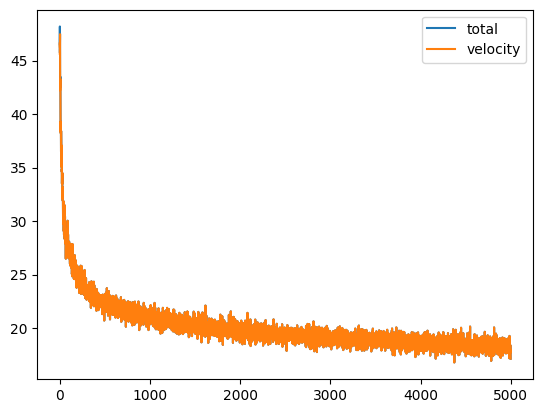

In [12]:
import matplotlib.pyplot as plt
plt.plot(losses,label='total')
plt.plot(v_losses,label='velocity')
# plt.plot(g_losses,label='growth')
plt.legend()

In [13]:
torch.save(f_net.state_dict(), os.path.join(exp_dir+'/pretrain_best_model'))

In [14]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/pretrain_best_model'),map_location=torch.device('cpu')))
optimizer = torch.optim.Adam(f_net.parameters(),lr=args.learning_rate2)

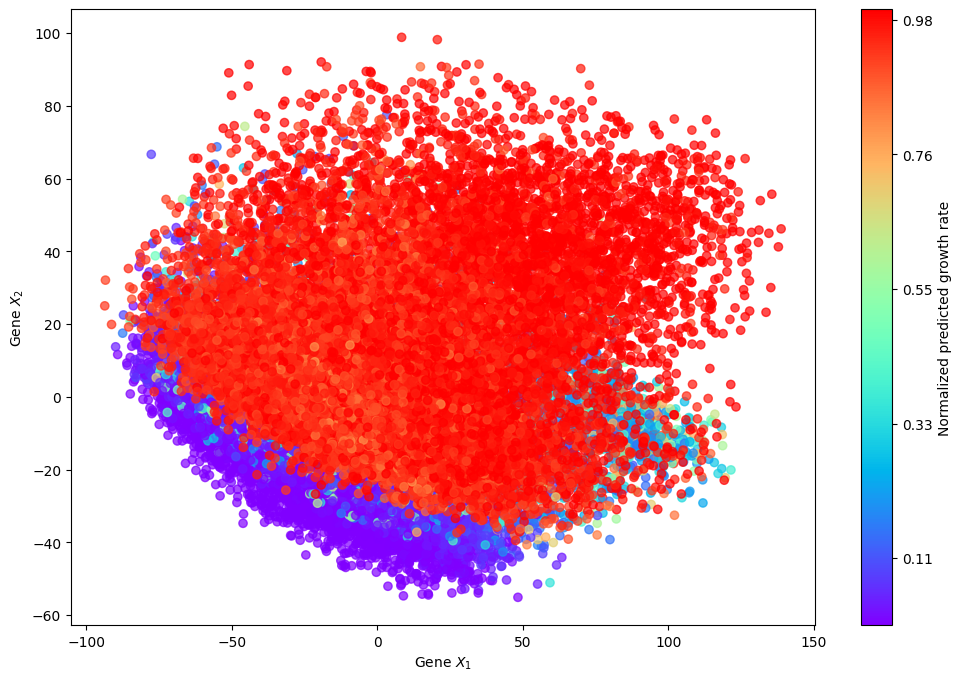

In [15]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        n = 50

        column_names = [f'x{i}' for i in range(1, n + 1)]

        tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]

        data = torch.stack(tensors, dim=1)
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g = f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 90)
    vmin_value = np.percentile(all_g_values, 10)
    
    norm = plt.Normalize(vmin=vmin_value, vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_pretrain.pdf')

In [16]:
groups = [0,1,2,3]
l_loss, b_loss, g_loss = train(
    f_net, df, groups, optimizer, 1, 
    criterion = criterion, use_cuda = use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=False, hold_out=-1, 
    sample_size = sample_size,relative_mass=relative_mass,initial_size=initial_size,
    sample_with_replacement = args.sample_with_replacement, logger=logger, device=device, best_model_path=exp_dir+'/test_model',stepsize=0.1
)

  0%|          | 0/1 [00:00<?, ?it/s]

epoch_0_0:
relative_mass_pred:0.9362266659736633,relative_mass_now:0.9361958266452648
RME:3.294110860229319e-05
Otloss:33.5293
total loss:33.5293
epoch_0_1:
relative_mass_pred:0.923175573348999,relative_mass_now:1.2722043873729267
RME:0.2743496386965496
Otloss:38.1297
total loss:38.1297
epoch_0_2:
relative_mass_pred:0.9395390152931213,relative_mass_now:0.9703049759229535
RME:0.0317075160833506
Otloss:43.4787
total loss:43.4787


d:\NeurIPS_2025_VGFM\VGFM\notebooks\..\VGFM\train.py:200: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  batch_loss = torch.Tensor(batch_loss).float()
100%|██████████| 1/1 [00:42<00:00, 42.33s/it]

New minimum otloss found: 43.478668212890625. Model saved.


In [17]:
# generate plot data
f_net.to('cpu')
generated, trajectories,_,_ = generate_plot_data(
    f_net, df, n_points=400, n_trajectories=50, n_bins=100, 
    sample_with_replacement=True, use_cuda=use_cuda, samples_key='samples',
    logger=logger
    )


tensor([0., 1., 2., 3.])
<class 'torch.Tensor'>
tensor([0.0000, 0.0303, 0.0606, 0.0909, 0.1212, 0.1515, 0.1818, 0.2121, 0.2424,
        0.2727, 0.3030, 0.3333, 0.3636, 0.3939, 0.4242, 0.4545, 0.4848, 0.5152,
        0.5455, 0.5758, 0.6061, 0.6364, 0.6667, 0.6970, 0.7273, 0.7576, 0.7879,
        0.8182, 0.8485, 0.8788, 0.9091, 0.9394, 0.9697, 1.0000, 1.0303, 1.0606,
        1.0909, 1.1212, 1.1515, 1.1818, 1.2121, 1.2424, 1.2727, 1.3030, 1.3333,
        1.3636, 1.3939, 1.4242, 1.4545, 1.4848, 1.5152, 1.5455, 1.5758, 1.6061,
        1.6364, 1.6667, 1.6970, 1.7273, 1.7576, 1.7879, 1.8182, 1.8485, 1.8788,
        1.9091, 1.9394, 1.9697, 2.0000, 2.0303, 2.0606, 2.0909, 2.1212, 2.1515,
        2.1818, 2.2121, 2.2424, 2.2727, 2.3030, 2.3333, 2.3636, 2.3939, 2.4242,
        2.4545, 2.4848, 2.5152, 2.5455, 2.5758, 2.6061, 2.6364, 2.6667, 2.6970,
        2.7273, 2.7576, 2.7879, 2.8182, 2.8485, 2.8788, 2.9091, 2.9394, 2.9697,
        3.0000])
<class 'torch.Tensor'>


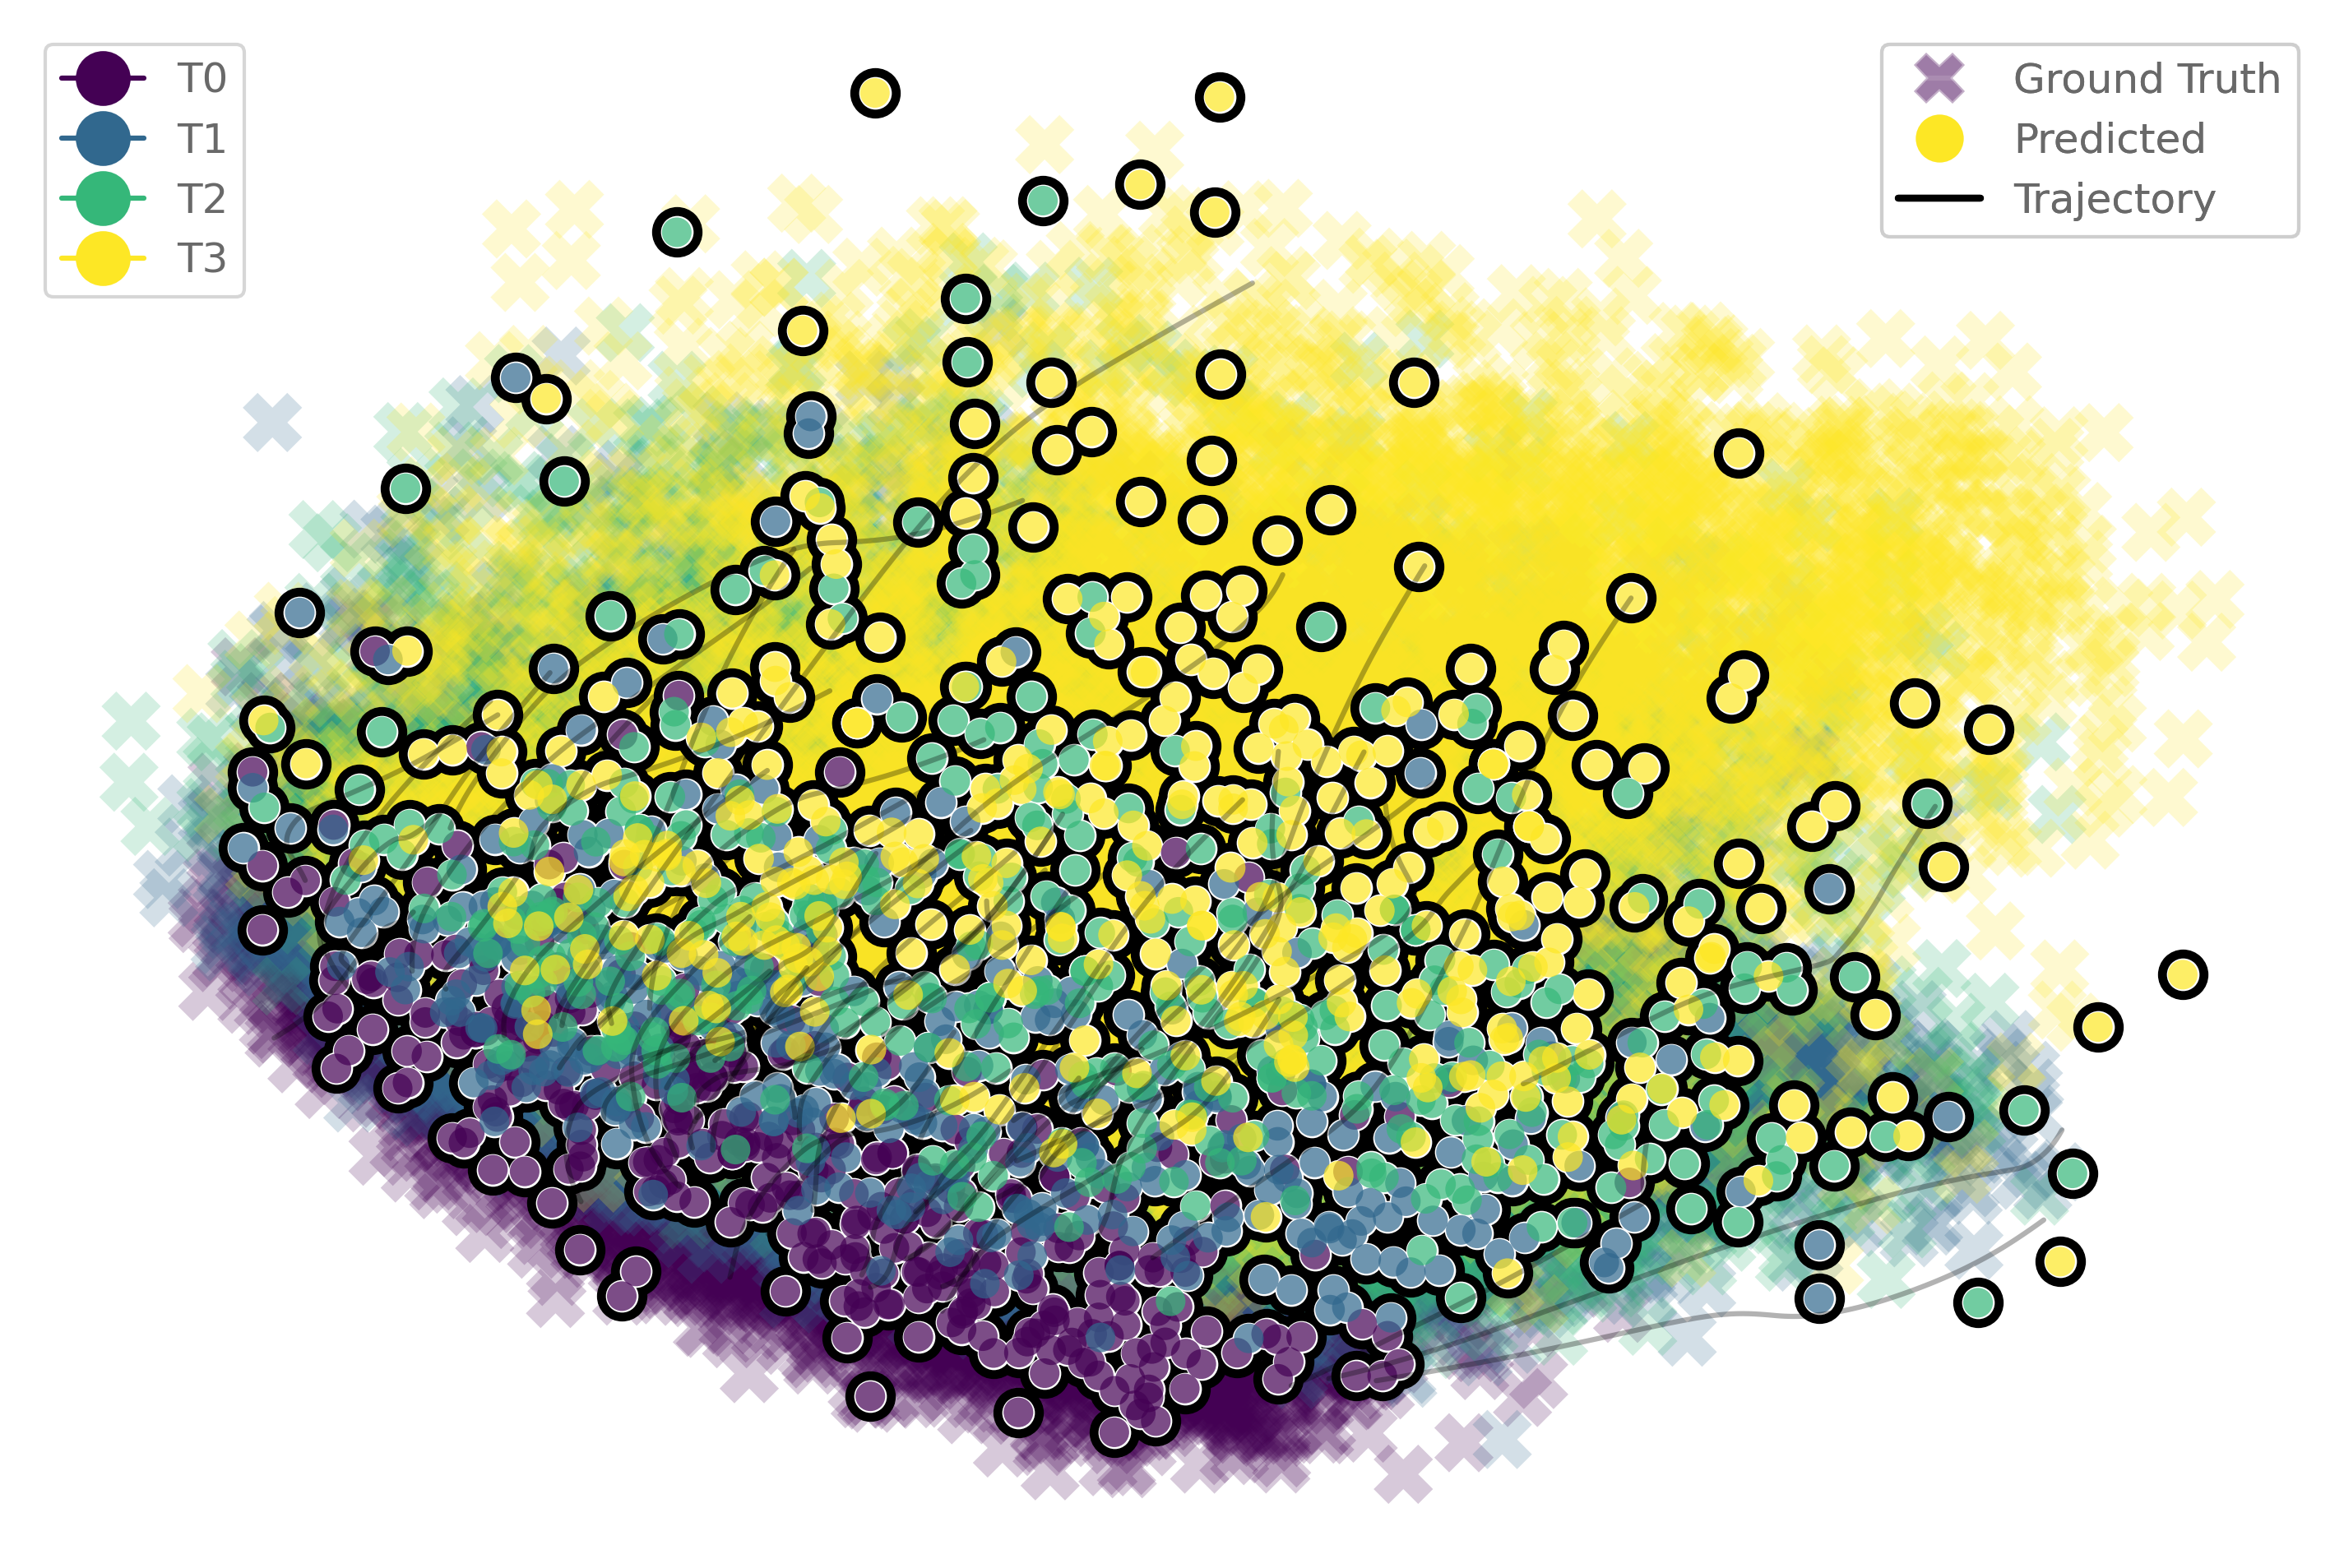

In [18]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='comparision_pretrain.png',
    x='x1', y='x2', is_3d=False
)

### Incorporating $\mathcal{L}_{\rm OT}$

Note: below, `relative_mass_now` is also displayed at the hold-out time points, which may cause a mismatch with `relative_mass_pred`. Please manually align the predicted and ground-truth time points when comparing them.

In [19]:
logger.info("Incorporating $L_{ot}$")

# 训练阶段
l_loss, b_loss, g_loss = train(
    f_net,
    df,
    groups,
    optimizer,
    args.epochs2,  # n_epoch
    criterion=criterion,
    use_cuda=use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=args.hold_one_out,
    hold_out=args.hold_out,
    sample_size=sample_size,
    relative_mass=relative_mass,
    initial_size=initial_size,
    sample_with_replacement=args.sample_with_replacement,
    logger=logger,
    device=device,
    best_model_path=exp_dir + "/best_model",
    stepsize=0.1,
)

# 累积损失
for k, v in l_loss.items():
    local_losses[k].extend(v)

batch_losses.extend(b_loss)
globe_losses.extend(g_loss)


  0%|          | 0/30 [00:00<?, ?it/s]

[(0, 1), (1, 3)]
epoch_0_0:
relative_mass_pred:0.9363160729408264,relative_mass_now:0.9361958266452648
RME:0.00012844139243015868
Otloss:31.5088
total loss:31.5088
epoch_0_1:
relative_mass_pred:0.9405489563941956,relative_mass_now:1.2722043873729267
RME:0.26069351298464877
Otloss:39.7925
total loss:39.7925


  3%|▎         | 1/30 [00:23<11:14, 23.24s/it]

New minimum otloss found: 39.79246520996094. Model saved.
[(0, 1), (1, 3)]
epoch_1_0:
relative_mass_pred:0.9363552331924438,relative_mass_now:0.9361958266452648
RME:0.00017027051674676374
Otloss:30.6198
total loss:30.6198
epoch_1_1:
relative_mass_pred:0.9408475160598755,relative_mass_now:1.2722043873729267
RME:0.26045883397501535
Otloss:36.8774
total loss:36.8774


  7%|▋         | 2/30 [00:46<10:59, 23.54s/it]

New minimum otloss found: 36.877376556396484. Model saved.
[(0, 1), (1, 3)]
epoch_2_0:
relative_mass_pred:0.9363733530044556,relative_mass_now:0.9361958266452648
RME:0.00018962524093587782
Otloss:29.9353
total loss:29.9353
epoch_2_1:
relative_mass_pred:0.9409540891647339,relative_mass_now:1.2722043873729267
RME:0.2603750635479392
Otloss:34.7771
total loss:34.7771


 10%|█         | 3/30 [01:08<10:12, 22.67s/it]

New minimum otloss found: 34.77705764770508. Model saved.
[(0, 1), (1, 3)]
epoch_3_0:
relative_mass_pred:0.936382532119751,relative_mass_now:0.9361958266452648
RME:0.00019942993674220533
Otloss:29.4746
total loss:29.4746
epoch_3_1:
relative_mass_pred:0.9411031007766724,relative_mass_now:1.2722043873729267
RME:0.26025793487473425
Otloss:34.4002
total loss:34.4002


 13%|█▎        | 4/30 [01:30<09:38, 22.25s/it]

New minimum otloss found: 34.40017318725586. Model saved.
[(0, 1), (1, 3)]
epoch_4_0:
relative_mass_pred:0.9363858699798584,relative_mass_now:0.9361958266452648
RME:0.00020299528067177898
Otloss:29.1606
total loss:29.1606
epoch_4_1:
relative_mass_pred:0.9412455558776855,relative_mass_now:1.2722043873729267
RME:0.26014595986315037
Otloss:34.069
total loss:34.069


 17%|█▋        | 5/30 [01:52<09:13, 22.12s/it]

New minimum otloss found: 34.06895065307617. Model saved.
[(0, 1), (1, 3)]
epoch_5_0:
relative_mass_pred:0.9363834857940674,relative_mass_now:0.9361958266452648
RME:0.00020044860643636924
Otloss:28.8992
total loss:28.8992
epoch_5_1:
relative_mass_pred:0.9413288235664368,relative_mass_now:1.2722043873729267
RME:0.26008050836056346
Otloss:32.9298
total loss:32.9298


 20%|██        | 6/30 [02:13<08:44, 21.84s/it]

New minimum otloss found: 32.92979049682617. Model saved.
[(0, 1), (1, 3)]
epoch_6_0:
relative_mass_pred:0.9363783597946167,relative_mass_now:0.9361958266452648
RME:0.0001949732568302383
Otloss:28.6591
total loss:28.6591
epoch_6_1:
relative_mass_pred:0.9413950443267822,relative_mass_now:1.2722043873729267
RME:0.26002845637819116
Otloss:32.0041
total loss:32.0041


 23%|██▎       | 7/30 [02:33<08:09, 21.30s/it]

New minimum otloss found: 32.00410842895508. Model saved.
[(0, 1), (1, 3)]
epoch_7_0:
relative_mass_pred:0.9363729357719421,relative_mass_now:0.9361958266452648
RME:0.0001891795729446811
Otloss:28.439
total loss:28.439
epoch_7_1:
relative_mass_pred:0.9414634704589844,relative_mass_now:1.2722043873729267
RME:0.2599746708914555
Otloss:31.8278
total loss:31.8278


 27%|██▋       | 8/30 [02:54<07:43, 21.05s/it]

New minimum otloss found: 31.82775115966797. Model saved.
[(0, 1), (1, 3)]
epoch_8_0:
relative_mass_pred:0.9363664388656616,relative_mass_now:0.9361958266452648
RME:0.00018223988565318957
Otloss:28.2449
total loss:28.2449
epoch_8_1:
relative_mass_pred:0.9415181875228882,relative_mass_now:1.2722043873729267
RME:0.2599316612426546
Otloss:31.8868
total loss:31.8868


 30%|███       | 9/30 [03:14<07:16, 20.79s/it]

[(0, 1), (1, 3)]
epoch_9_0:
relative_mass_pred:0.9363598823547363,relative_mass_now:0.9361958266452648
RME:0.00017523653150581275
Otloss:28.0722
total loss:28.0722
epoch_9_1:
relative_mass_pred:0.9415993690490723,relative_mass_now:1.2722043873729267
RME:0.25986784954149256
Otloss:31.8126
total loss:31.8126


 33%|███▎      | 10/30 [03:34<06:52, 20.62s/it]

New minimum otloss found: 31.812625885009766. Model saved.
[(0, 1), (1, 3)]
epoch_10_0:
relative_mass_pred:0.9363554120063782,relative_mass_now:0.9361958266452648
RME:0.00017046151731441947
Otloss:27.9188
total loss:27.9188
epoch_10_1:
relative_mass_pred:0.941713809967041,relative_mass_now:1.2722043873729267
RME:0.2597778947204712
Otloss:31.4138
total loss:31.4138


 37%|███▋      | 11/30 [03:55<06:31, 20.59s/it]

New minimum otloss found: 31.413806915283203. Model saved.
[(0, 1), (1, 3)]
epoch_11_0:
relative_mass_pred:0.9363546371459961,relative_mass_now:0.9361958266452648
RME:0.00016963384818791133
Otloss:27.7858
total loss:27.7858
epoch_11_1:
relative_mass_pred:0.9418898224830627,relative_mass_now:1.2722043873729267
RME:0.2596395423316815
Otloss:30.9414
total loss:30.9414


 40%|████      | 12/30 [04:15<06:09, 20.54s/it]

New minimum otloss found: 30.94144058227539. Model saved.
[(0, 1), (1, 3)]
epoch_12_0:
relative_mass_pred:0.9363573789596558,relative_mass_now:0.9361958266452648
RME:0.00017256252355863253
Otloss:27.6766
total loss:27.6766
epoch_12_1:
relative_mass_pred:0.9421635270118713,relative_mass_now:1.2722043873729267
RME:0.25942440038473874
Otloss:30.7277
total loss:30.7277


 43%|████▎     | 13/30 [04:35<05:44, 20.28s/it]

New minimum otloss found: 30.72765350341797. Model saved.
[(0, 1), (1, 3)]
epoch_13_0:
relative_mass_pred:0.9363632202148438,relative_mass_now:0.9361958266452648
RME:0.0001788018754353864
Otloss:27.5842
total loss:27.5842
epoch_13_1:
relative_mass_pred:0.9425216913223267,relative_mass_now:1.2722043873729267
RME:0.25914286990582336
Otloss:30.6551
total loss:30.6551


 47%|████▋     | 14/30 [04:54<05:20, 20.03s/it]

New minimum otloss found: 30.65512466430664. Model saved.
[(0, 1), (1, 3)]
epoch_14_0:
relative_mass_pred:0.9363715648651123,relative_mass_now:0.9361958266452648
RME:0.00018771523525932052
Otloss:27.4968
total loss:27.4968
epoch_14_1:
relative_mass_pred:0.9429332613945007,relative_mass_now:1.2722043873729267
RME:0.25881936051043136
Otloss:30.4345
total loss:30.4345


 50%|█████     | 15/30 [05:13<04:55, 19.71s/it]

New minimum otloss found: 30.434478759765625. Model saved.
[(0, 1), (1, 3)]
epoch_15_0:
relative_mass_pred:0.9363820552825928,relative_mass_now:0.9361958266452648
RME:0.0001989206018951234
Otloss:27.4098
total loss:27.4098
epoch_15_1:
relative_mass_pred:0.9433865547180176,relative_mass_now:1.2722043873729267
RME:0.258463055086542
Otloss:30.0954
total loss:30.0954


 53%|█████▎    | 16/30 [05:32<04:33, 19.50s/it]

New minimum otloss found: 30.095413208007812. Model saved.
[(0, 1), (1, 3)]
epoch_16_0:
relative_mass_pred:0.9363958239555359,relative_mass_now:0.9361958266452648
RME:0.00021362764560461467
Otloss:27.3281
total loss:27.3281
epoch_16_1:
relative_mass_pred:0.9438796639442444,relative_mass_now:1.2722043873729267
RME:0.25807545288117223
Otloss:29.8731
total loss:29.8731


 57%|█████▋    | 17/30 [05:51<04:10, 19.25s/it]

New minimum otloss found: 29.87311553955078. Model saved.
[(0, 1), (1, 3)]
epoch_17_0:
relative_mass_pred:0.9364125728607178,relative_mass_now:0.9361958266452648
RME:0.00023151803210836816
Otloss:27.2597
total loss:27.2597
epoch_17_1:
relative_mass_pred:0.9443921446800232,relative_mass_now:1.2722043873729267
RME:0.2576726239482859
Otloss:29.7844
total loss:29.7844


 60%|██████    | 18/30 [06:09<03:47, 18.93s/it]

New minimum otloss found: 29.7844181060791. Model saved.
[(0, 1), (1, 3)]
epoch_18_0:
relative_mass_pred:0.9364315271377563,relative_mass_now:0.9361958266452648
RME:0.0002517640922798756
Otloss:27.2045
total loss:27.2045
epoch_18_1:
relative_mass_pred:0.9448866844177246,relative_mass_now:1.2722043873729267
RME:0.25728389730765333
Otloss:29.6762
total loss:29.6762


 63%|██████▎   | 19/30 [06:28<03:27, 18.86s/it]

New minimum otloss found: 29.676219940185547. Model saved.
[(0, 1), (1, 3)]
epoch_19_0:
relative_mass_pred:0.9364506006240845,relative_mass_now:0.9361958266452648
RME:0.0002721374861631536
Otloss:27.16
total loss:27.16
epoch_19_1:
relative_mass_pred:0.9453203082084656,relative_mass_now:1.2722043873729267
RME:0.256943052868627
Otloss:29.5137
total loss:29.5137


 67%|██████▋   | 20/30 [06:46<03:08, 18.84s/it]

New minimum otloss found: 29.51370620727539. Model saved.
[(0, 1), (1, 3)]
epoch_20_0:
relative_mass_pred:0.936467170715332,relative_mass_now:0.9361958266452648
RME:0.00028983687209925134
Otloss:27.1228
total loss:27.1228
epoch_20_1:
relative_mass_pred:0.9456748962402344,relative_mass_now:1.2722043873729267
RME:0.2566643334778686
Otloss:29.3821
total loss:29.3821


 70%|███████   | 21/30 [07:05<02:48, 18.71s/it]

New minimum otloss found: 29.382083892822266. Model saved.
[(0, 1), (1, 3)]
epoch_21_0:
relative_mass_pred:0.936478853225708,relative_mass_now:0.9361958266452648
RME:0.0003023155758527591
Otloss:27.0875
total loss:27.0875
epoch_21_1:
relative_mass_pred:0.94594407081604,relative_mass_now:1.2722043873729267
RME:0.2564527522425912
Otloss:29.2516
total loss:29.2516


 73%|███████▎  | 22/30 [07:36<02:58, 22.34s/it]

New minimum otloss found: 29.251567840576172. Model saved.
[(0, 1), (1, 3)]
epoch_22_0:
relative_mass_pred:0.9364848136901855,relative_mass_now:0.9361958266452648
RME:0.00030868226144128345
Otloss:27.0472
total loss:27.0472
epoch_22_1:
relative_mass_pred:0.9461233615875244,relative_mass_now:1.2722043873729267
RME:0.25631182302299105
Otloss:29.0996
total loss:29.0996


 77%|███████▋  | 23/30 [08:12<03:05, 26.44s/it]

New minimum otloss found: 29.09961700439453. Model saved.
[(0, 1), (1, 3)]
epoch_23_0:
relative_mass_pred:0.9364863634109497,relative_mass_now:0.9361958266452648
RME:0.0003103375996942998
Otloss:27.0026
total loss:27.0026
epoch_23_1:
relative_mass_pred:0.946258008480072,relative_mass_now:1.2722043873729267
RME:0.2562059855538831
Otloss:29.0827
total loss:29.0827


 80%|████████  | 24/30 [08:32<02:27, 24.52s/it]

New minimum otloss found: 29.082698822021484. Model saved.
[(0, 1), (1, 3)]
epoch_24_0:
relative_mass_pred:0.9364863634109497,relative_mass_now:0.9361958266452648
RME:0.0003103375996942998
Otloss:26.9593
total loss:26.9593
epoch_24_1:
relative_mass_pred:0.9463863372802734,relative_mass_now:1.2722043873729267
RME:0.25610511434051897
Otloss:29.1036
total loss:29.1036


 83%|████████▎ | 25/30 [08:50<01:53, 22.61s/it]

[(0, 1), (1, 3)]
epoch_25_0:
relative_mass_pred:0.9364873170852661,relative_mass_now:0.9361958266452648
RME:0.0003113562693884637
Otloss:26.9209
total loss:26.9209
epoch_25_1:
relative_mass_pred:0.9465178847312927,relative_mass_now:1.2722043873729267
RME:0.25600171314781367
Otloss:29.0293
total loss:29.0293


 87%|████████▋ | 26/30 [09:08<01:25, 21.31s/it]

New minimum otloss found: 29.029333114624023. Model saved.
[(0, 1), (1, 3)]
epoch_26_0:
relative_mass_pred:0.936489999294281,relative_mass_now:0.9361958266452648
RME:0.00031422127790329966
Otloss:26.8873
total loss:26.8873
epoch_26_1:
relative_mass_pred:0.9466398358345032,relative_mass_now:1.2722043873729267
RME:0.25590585504166274
Otloss:28.8761
total loss:28.8761


 90%|█████████ | 27/30 [09:26<01:00, 20.24s/it]

New minimum otloss found: 28.87611961364746. Model saved.
[(0, 1), (1, 3)]
epoch_27_0:
relative_mass_pred:0.9364947080612183,relative_mass_now:0.9361958266452648
RME:0.0003192509595182339
Otloss:26.8562
total loss:26.8562
epoch_27_1:
relative_mass_pred:0.9467414021492004,relative_mass_now:1.2722043873729267
RME:0.25582602013800626
Otloss:28.7783
total loss:28.7783


 93%|█████████▎| 28/30 [09:44<00:38, 19.46s/it]

New minimum otloss found: 28.778263092041016. Model saved.
[(0, 1), (1, 3)]
epoch_28_0:
relative_mass_pred:0.9365012645721436,relative_mass_now:0.9361958266452648
RME:0.0003262543136656107
Otloss:26.8241
total loss:26.8241
epoch_28_1:
relative_mass_pred:0.9468156099319458,relative_mass_now:1.2722043873729267
RME:0.2557676900587502
Otloss:28.752
total loss:28.752


 97%|█████████▋| 29/30 [10:02<00:19, 19.03s/it]

New minimum otloss found: 28.751996994018555. Model saved.
[(0, 1), (1, 3)]
epoch_29_0:
relative_mass_pred:0.9365090727806091,relative_mass_now:0.9361958266452648
RME:0.0003345946717865776
Otloss:26.7895
total loss:26.7895
epoch_29_1:
relative_mass_pred:0.9468664526939392,relative_mass_now:1.2722043873729267
RME:0.2557277257554527
Otloss:28.6904
total loss:28.6904


100%|██████████| 30/30 [10:20<00:00, 20.69s/it]

New minimum otloss found: 28.69035530090332. Model saved.


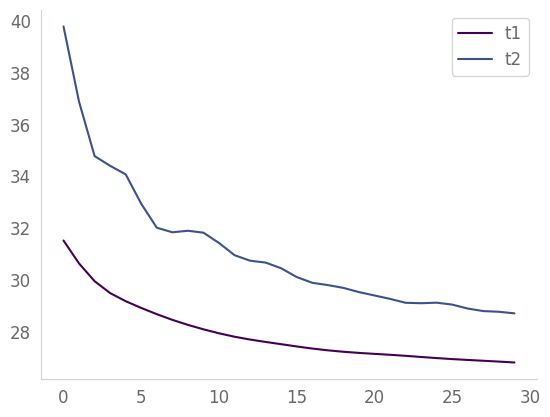

In [20]:
plt.plot(l_loss[f'0:1'],label = 't1')
plt.plot(l_loss[f'1:3'],label = 't2')
plt.legend()

### Test

In [21]:
f_net.load_state_dict(torch.load(os.path.join(exp_dir+'/best_model'),map_location=torch.device('cpu')))

<All keys matched successfully>

In [22]:
groups =[0,1,2,3] #including the hold-out time point

For simplicity, we present the prediction results using function `train` by setting `epoch=1`, `hold_one_out=False` and `hold_out=-1`, one just need to focus on the **hold-out** time points.  
For example, if the hold-out time point is **n**, then the **OT loss of `epoch0_{n-1}`** corresponds to the **EMD at the hold-out time point**.


In [23]:
l_loss, b_loss, g_loss = train(
    f_net, df, groups, optimizer, 1, 
    criterion = criterion, use_cuda = use_cuda,
    apply_losses_in_time=args.apply_losses_in_time,
    hold_one_out=False, hold_out=-1, 
    sample_size = sample_size,relative_mass=relative_mass,initial_size=initial_size,
    sample_with_replacement = args.sample_with_replacement, logger=logger, device=device, best_model_path=exp_dir+'/test_model',stepsize=0.1
)

  0%|          | 0/1 [00:00<?, ?it/s]

epoch_0_0:
relative_mass_pred:0.9365178346633911,relative_mass_now:0.9361958266452648
RME:0.00034395369960170847
Otloss:26.7548
total loss:26.7548
epoch_0_1:
relative_mass_pred:0.9295482635498047,relative_mass_now:1.2722043873729267
RME:0.2693404670067985
Otloss:36.4623
total loss:36.4623
epoch_0_2:
relative_mass_pred:0.9469226002693176,relative_mass_now:0.9703049759229535
RME:0.02409796531383813
Otloss:28.6155
total loss:28.6155


100%|██████████| 1/1 [00:34<00:00, 34.53s/it]

New minimum otloss found: 28.61554718017578. Model saved.


In [24]:
# generate plot data
f_net.to('cpu')
generated, trajectories,generated_weights,trajectories_weights = generate_plot_data(
    f_net, df, n_points=400, n_trajectories=50, n_bins=100, 
    sample_with_replacement=True, use_cuda=use_cuda, samples_key='samples',
    logger=logger
    )


tensor([0., 1., 2., 3.])
<class 'torch.Tensor'>
tensor([0.0000, 0.0303, 0.0606, 0.0909, 0.1212, 0.1515, 0.1818, 0.2121, 0.2424,
        0.2727, 0.3030, 0.3333, 0.3636, 0.3939, 0.4242, 0.4545, 0.4848, 0.5152,
        0.5455, 0.5758, 0.6061, 0.6364, 0.6667, 0.6970, 0.7273, 0.7576, 0.7879,
        0.8182, 0.8485, 0.8788, 0.9091, 0.9394, 0.9697, 1.0000, 1.0303, 1.0606,
        1.0909, 1.1212, 1.1515, 1.1818, 1.2121, 1.2424, 1.2727, 1.3030, 1.3333,
        1.3636, 1.3939, 1.4242, 1.4545, 1.4848, 1.5152, 1.5455, 1.5758, 1.6061,
        1.6364, 1.6667, 1.6970, 1.7273, 1.7576, 1.7879, 1.8182, 1.8485, 1.8788,
        1.9091, 1.9394, 1.9697, 2.0000, 2.0303, 2.0606, 2.0909, 2.1212, 2.1515,
        2.1818, 2.2121, 2.2424, 2.2727, 2.3030, 2.3333, 2.3636, 2.3939, 2.4242,
        2.4545, 2.4848, 2.5152, 2.5455, 2.5758, 2.6061, 2.6364, 2.6667, 2.6970,
        2.7273, 2.7576, 2.7879, 2.8182, 2.8485, 2.8788, 2.9091, 2.9394, 2.9697,
        3.0000])
<class 'torch.Tensor'>


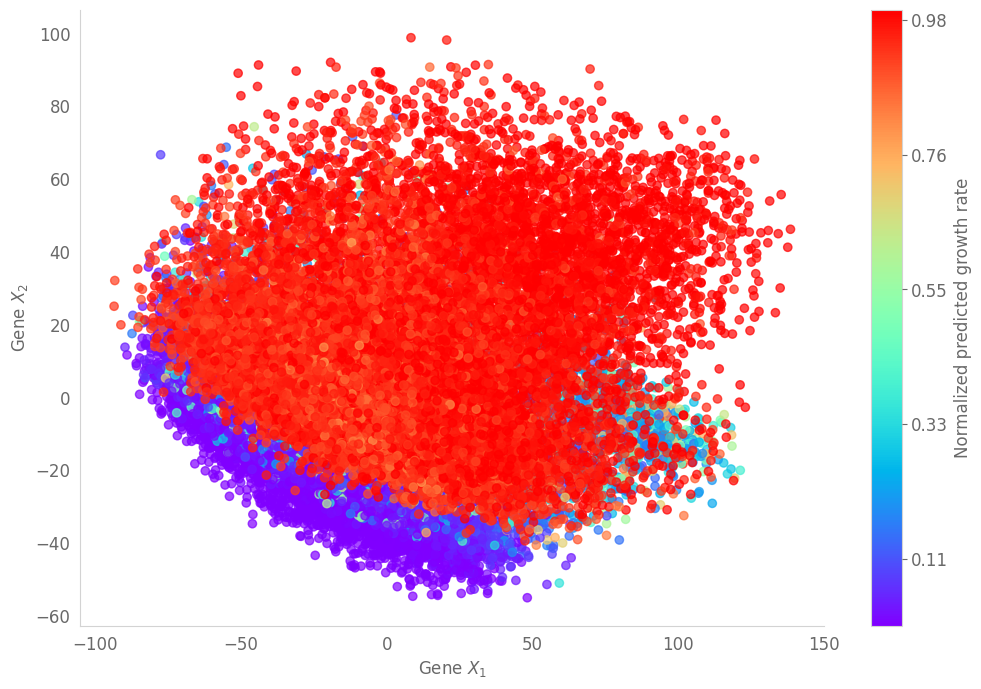

In [25]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_g_values(df, f_net, device=device, output_file='plot.pdf'):
    time_points = df['samples'].unique()
    
    data_by_time = {}
    
    for time in time_points:
        subset = df[df['samples'] == time]
        n = 50

        column_names = [f'x{i}' for i in range(1, n + 1)]

        tensors = [torch.tensor(subset[col].values, dtype=torch.float32).to(device) for col in column_names]

        data = torch.stack(tensors, dim=1)
        with torch.no_grad():
            t = torch.tensor([time], dtype=torch.float32).to(device)
            _, g = f_net(t, data)
        
        data_by_time[time] = {'data': subset, 'g_values': g.detach().cpu().numpy()}
    
    all_g_values = np.concatenate([content['g_values'] for content in data_by_time.values()])
    
    vmax_value = np.percentile(all_g_values, 90)
    vmin_value = np.percentile(all_g_values, 10)
    
    norm = plt.Normalize(vmin=vmin_value, vmax=vmax_value, clip=True)
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    for time, content in data_by_time.items():
        subset = content['data']
        g_values = content['g_values']
        x = subset['x1']
        y = subset['x2']
        
        colors = plt.cm.rainbow(norm(g_values))
        
        ax.scatter(x, y, color=colors, label=f'Time {time}', alpha=0.7, marker='o')
    
    ax.set_xlabel('Gene $X_1$')
    ax.set_ylabel('Gene $X_2$')
    
    sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
    sm.set_array(all_g_values)
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Normalized predicted growth rate')
    
    cbar.ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{norm(x):.2f}'))
    
    plt.show()

plot_g_values(df, f_net, output_file='gene_growth_final.pdf')

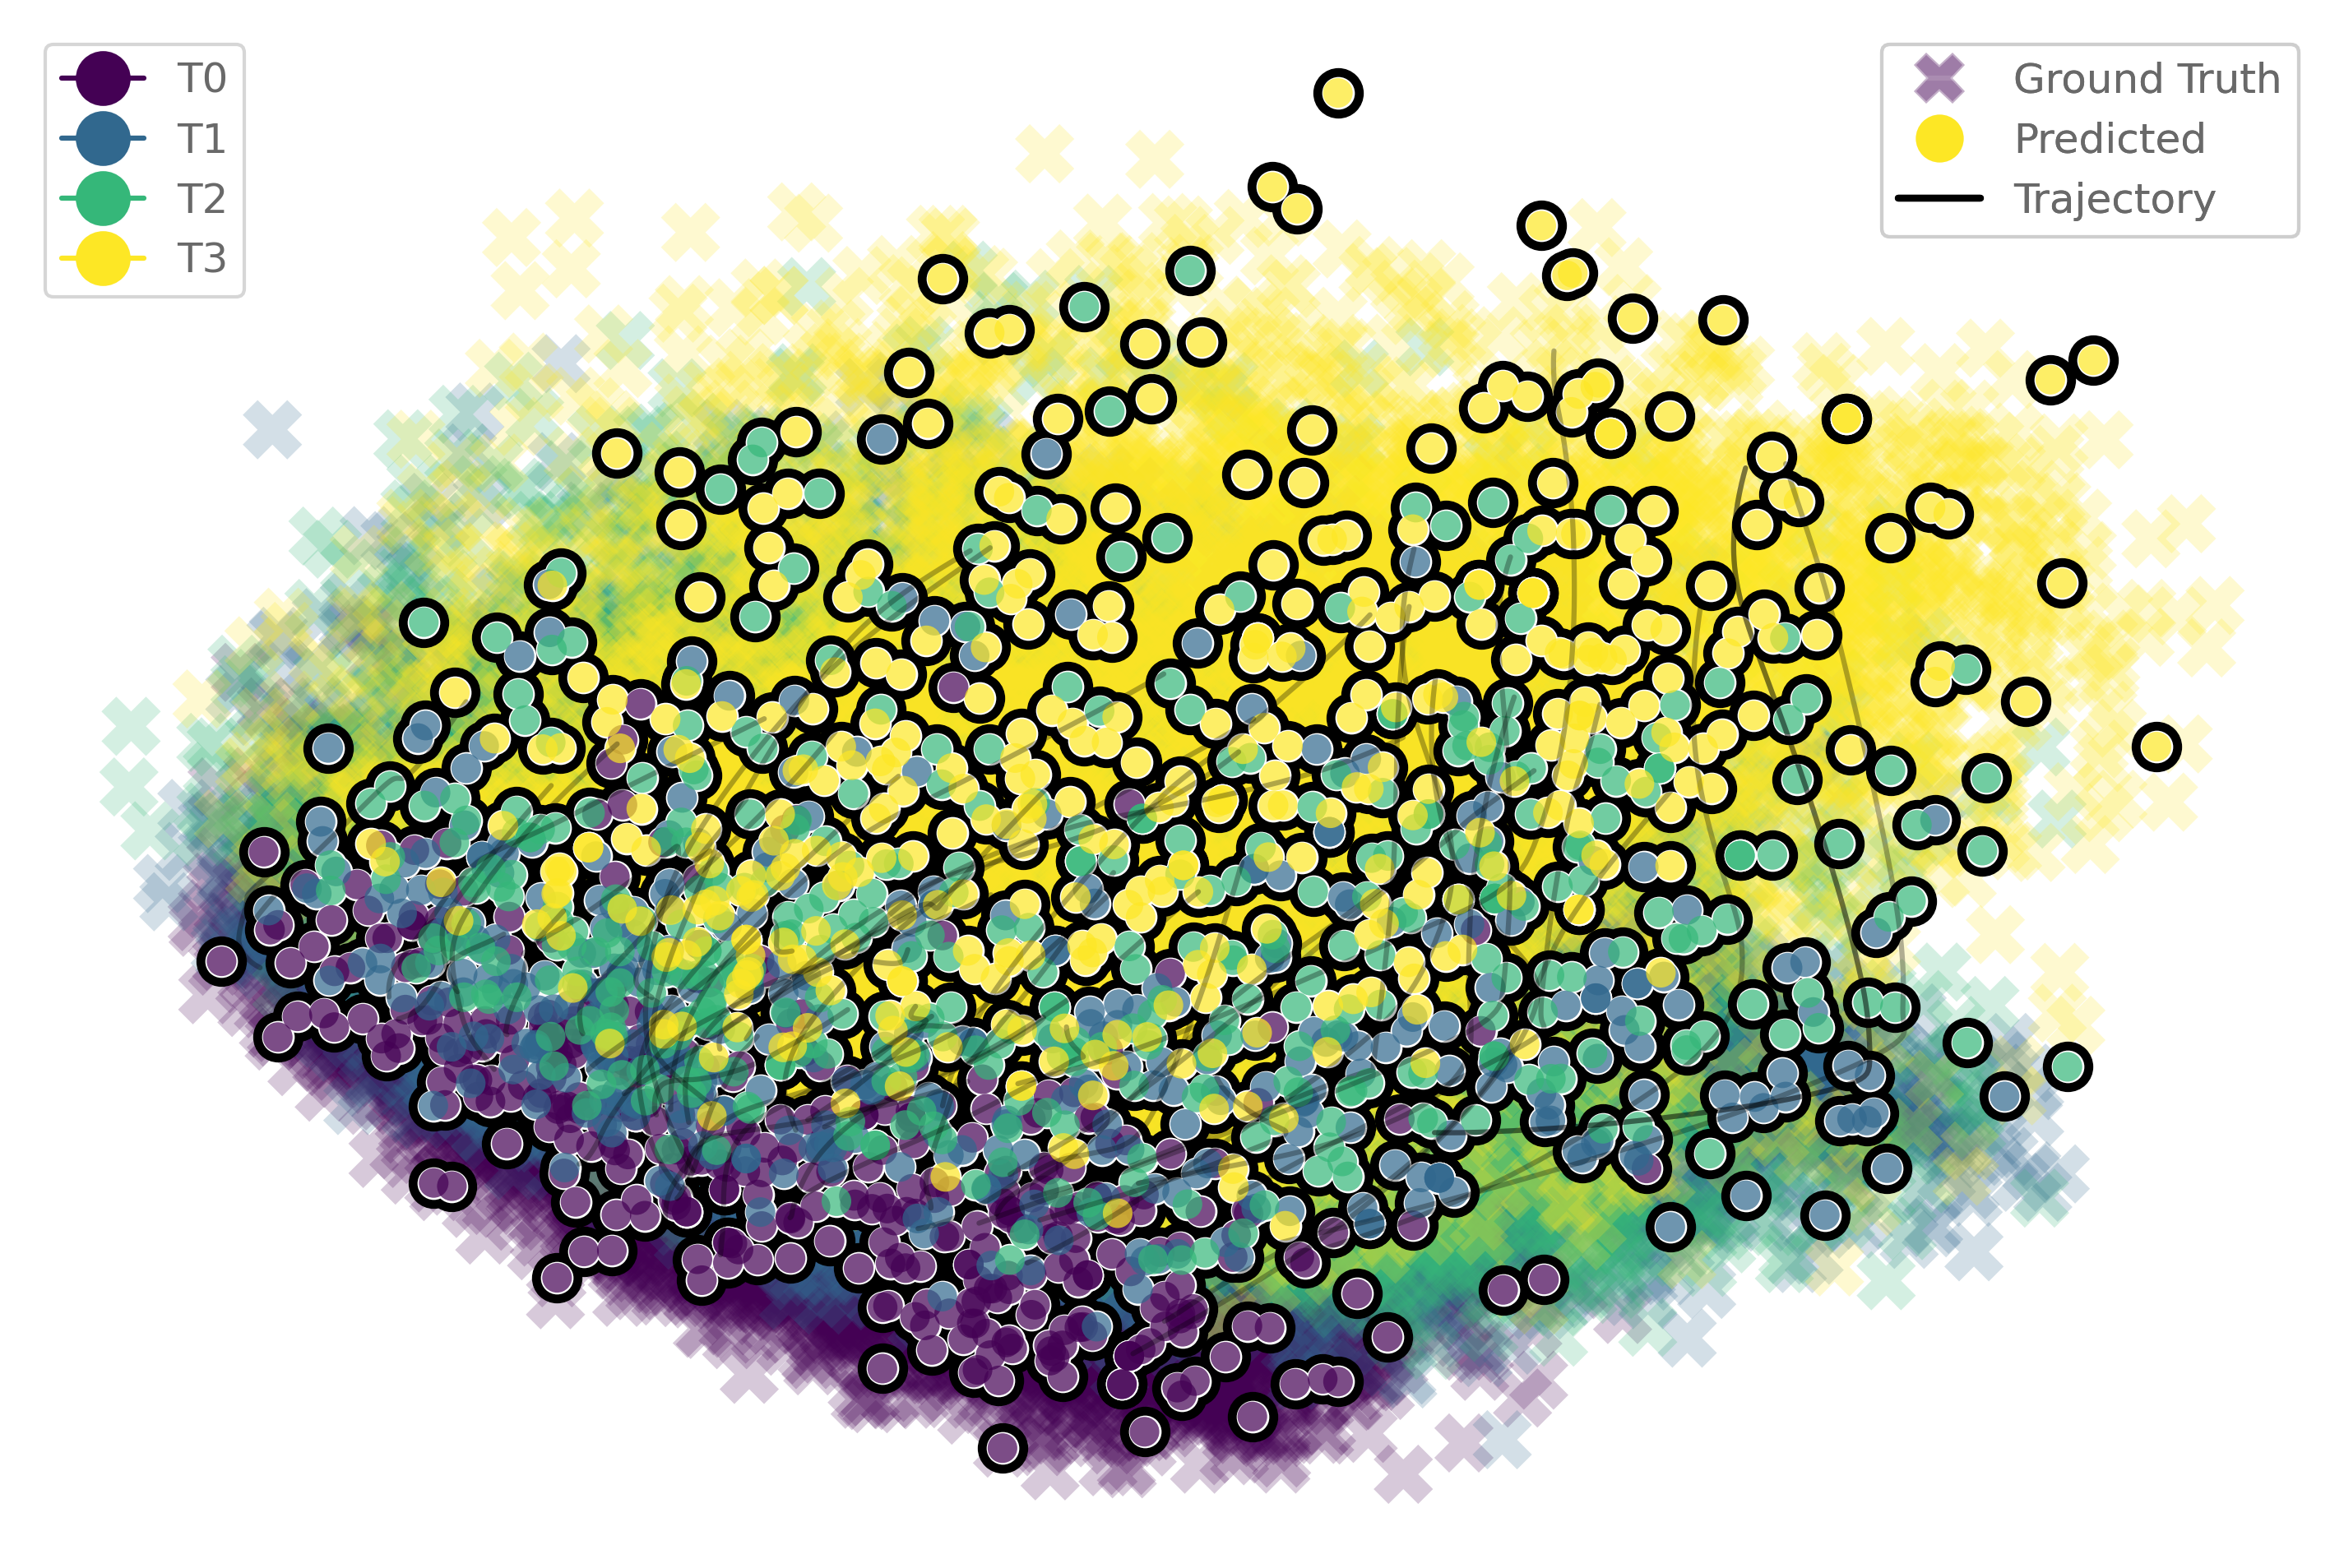

In [26]:
plot_comparision(
    df, generated, trajectories,
    palette = 'viridis', df_time_key='samples',
    save=True, path=exp_dir, file='comparision_final.png',
    x='x1', y='x2', is_3d=False
)